# Week 2 - Preprocessing, part 2

# 1. Lesson: None

# 2. Weekly graph question

The Storytelling With Data book mentions planning on a "Who, What, and How" for your data story.  Write down a possible Who, What, and How for your data, using the ideas in the book.

In [1]:
# Who, What, and How Summary for Manufacturing Defects Dataset

# Who: The primary audience is the quality control team and manufacturing managers, but may include other audiences such as
# various levels of decision-makers/leadership in order to make the proper investments to subvert costs or increase revenew.
# They need insights into defect trends to improve production efficiency and reduce waste.

# What: The key takeaway is to identify the most common manufacturing defects,
# analyze defect rates over time, and determine any patterns related to specific production lines or shifts.
# This will help managers implement targeted quality control measures.

# How: The best way to present this information is through:
# - Bar charts to show defect frequency by type.
# - Line graphs to track defect rates over time.
# - Heatmaps to highlight high-defect areas in different production stages.
# - Scatter plots to visualize defect types by production line or shift.


This week, you will do the same types of exercises as last week, but you should use your own datasets that you found last semester.

### Here are some types of analysis you can do  Use Google, documentation, and ChatGPT to help you:

- Summarize the datasets using info() and describe()

- Are there any duplicate rows?

- Are there any duplicate values in a given column (when this would be inappropriate?)

- What are the mean, median, and mode of each column?

- Are there any missing or null values?

    - Do you want to fill in the missing value with a mean value?  A value of your choice?  Remove that row?

- Identify any other inconsistent data (e.g. someone seems to be taking an action before they are born.)

- Encode any categorical variables (e.g. with one-hot encoding.)

### Conclusions:

- Are the data usable?  If not, find some new data!

- Do you need to modify or correct the data in some way?

- Is there any class imbalance?  (Categories that have many more items than other categories).

# 3. Homework - work with your own data

### 3a. Data Collection, Pre-Processing, Processing, & Mining

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
import random
import io
from datetime import datetime, timedelta

In [4]:
# API to download the dataset from Kaggle
# I wanted a way to pull the data from Kaggle without having to download the dataset manually. 
# I logged into my Kaggle account and generated an API token.
# I leveraged ChatGPT to determine the best way to download the dataset leveraging the Kaggle API.

from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile

# Initialize and authenticate the API
api = KaggleApi()
api.authenticate()

# Define the dataset
dataset = 'fahmidachowdhury/manufacturing-defects'

# Download the entire dataset as a zip file
api.dataset_download_files(dataset, path='.', unzip=True)

# Find the correct CSV filename
for file in os.listdir('.'):
    if file.endswith('.csv'):
        csv_filename = file
        break

# Load the dataset into a Pandas DataFrame
df_defects = pd.read_csv("defects_data.csv")


Dataset URL: https://www.kaggle.com/datasets/fahmidachowdhury/manufacturing-defects


In [6]:
# Step 1: Preview the Data

# Display the first few rows of the DataFrame
print("Initial Data Preview:")
print(df_defects.head())


Initial Data Preview:
   defect_id  product_id defect_type defect_date defect_location  severity  \
0          1          15  Structural    6/6/2024       Component     Minor   
1          2           6  Functional   4/26/2024       Component     Minor   
2          3          84  Structural   2/15/2024        Internal     Minor   
3          4          10  Functional   3/28/2024        Internal  Critical   
4          5          14    Cosmetic   4/26/2024       Component     Minor   

   inspection_method  repair_cost  
0  Visual Inspection       245.47  
1  Visual Inspection        26.87  
2  Automated Testing       835.81  
3  Automated Testing       444.47  
4     Manual Testing       823.64  


In [ ]:
# Step 2: Inspect the Data

# Display basic information about the DataFrame
print("\nDataFrame Information:")
df_defects.info()

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df_defects.describe())

# Display summary statistics (percentiles) for all columns
df_defects.describe(percentiles=[0.25, 0.5, 0.75], include='all')

# Display the number of missing values in each column
print("\nMissing Values per Column:")
print(df_defects.isnull().sum())


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB

Summary Statistics:
         defect_id   product_id  repair_cost
count  1000.000000  1000.000000  1000.000000
mean    500.500000    50.837000   507.627150
std     288.819436    29.480935   289.623615
min       1.000000     1.000000    10.220000
25%     250.750000    26.000000   270.902500
50%     500.500000    51.000000   506

In [9]:
df_defects_datefix = df_defects.copy()  # Create a separate copy
df_defects['defect_date'] = pd.to_datetime(df_defects['defect_date'], format='%m/%d/%Y', errors='coerce')
df_defects_datefix['Month_Year'] = df_defects_datefix['defect_date'].dt.to_period('M')
df_defects_datefix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   defect_id          1000 non-null   int64         
 1   product_id         1000 non-null   int64         
 2   defect_type        1000 non-null   object        
 3   defect_date        1000 non-null   datetime64[ns]
 4   defect_location    1000 non-null   object        
 5   severity           1000 non-null   object        
 6   inspection_method  1000 non-null   object        
 7   repair_cost        1000 non-null   float64       
 8   Month_Year         1000 non-null   period[M]     
dtypes: datetime64[ns](1), float64(1), int64(2), object(4), period[M](1)
memory usage: 70.4+ KB


In [10]:
# Identify columns that may have empty strings or whitespace instead of NaN
print("Checking for NaN values:")
print(df_defects_datefix.isnull().sum())  # Standard check

Checking for NaN values:
defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
Month_Year           0
dtype: int64


In [11]:
# Check for empty strings ("")
print("\nChecking for empty strings in each column:")
print((df_defects_datefix == "").sum())


Checking for empty strings in each column:
defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
Month_Year           0
dtype: int64


In [12]:
# Check for whitespace-only strings
print("\nChecking for whitespace-only values:")
print((df_defects_datefix.map(lambda x: isinstance(x, str) and x.strip() == "")).sum())


Checking for whitespace-only values:
defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
Month_Year           0
dtype: int64


In [13]:
# Drop rows where any column has NaN
#df_defects_datefix = df_defects_datefix.dropna()

# Fill Nans with "Unknown"
df_defects_datefix = df_defects_datefix.fillna({
    "defect_location": "Unknown",
    "defect_type": "Unknown",
    "inspection_method": "Unknown"
})


In [14]:
# Find exact duplicate rows (considering all columns)
duplicate_rows = df_defects_datefix[df_defects_datefix.duplicated(keep=False)]

# Display duplicate rows if found
if not duplicate_rows.empty:
    print("Duplicate rows found:")
    print(duplicate_rows)
    duplicate_rows.to_csv("duplicate_rows.csv", index=False)
    print("Duplicate rows saved as 'duplicate_rows.csv'.")
else:
    print("No duplicate rows found.")


No duplicate rows found.


In [15]:
# Pivot table: Count defect_id by defect_type per Month/Year
pivot_defects_type = df_defects_datefix.pivot_table(
    index='Month_Year', 
    columns='defect_type', 
    values='defect_id', 
    aggfunc='count'
)
print(pivot_defects_type)

defect_type  Cosmetic  Functional  Structural
Month_Year                                   
2024-01            65          56          70
2024-02            47          55          58
2024-03            46          67          62
2024-04            49          52          55
2024-05            57          66          44
2024-06            45          43          63


In [16]:
# Pivot table: Sum repair_cost per product_id per Month/Year
pivot_costs_product = df_defects_datefix.pivot_table(
    index='Month_Year', 
    values='repair_cost', 
    aggfunc='sum'
)
print(pivot_costs_product)

            repair_cost
Month_Year             
2024-01        95978.43
2024-02        83259.84
2024-03        91806.75
2024-04        76153.46
2024-05        83841.50
2024-06        76587.17


In [17]:
#Identifying Products with the Highest Defect Rates
defect_rate = df_defects.groupby('product_id')['defect_id'].count() / len(df_defects)
print(defect_rate.sort_values(ascending=False))

product_id
81    0.020
63    0.020
97    0.019
56    0.018
4     0.016
      ...  
19    0.004
89    0.004
52    0.004
85    0.004
55    0.003
Name: defect_id, Length: 100, dtype: float64


In [18]:
#Defect Count by Location
location_analysis = df_defects.groupby('defect_location')['defect_id'].count()
print(location_analysis.sort_values(ascending=False))

defect_location
Surface      353
Component    326
Internal     321
Name: defect_id, dtype: int64


In [19]:
#Top 5 Defective Products
top_defective_products = df_defects['product_id'].value_counts().head(5)
print(top_defective_products)

product_id
81    20
63    20
97    19
56    18
10    16
Name: count, dtype: int64


In [20]:
# Define categorical columns to encode
categorical_columns = ["defect_type", "defect_location", "severity", "inspection_method"]

# Perform one-hot encoding
#df_defects_encoded = pd.get_dummies(df_defects_datefix, columns=categorical_columns, prefix=categorical_columns)

# Perform one-hot encoding while ensuring the output is integer (0/1)
df_defects_encoded = pd.get_dummies(df_defects_datefix, columns=categorical_columns, prefix=categorical_columns, dtype=int)

# Display the first few rows
print(df_defects_encoded.head())

   defect_id  product_id defect_date  repair_cost Month_Year  \
0          1          15  2024-06-06       245.47    2024-06   
1          2           6  2024-04-26        26.87    2024-04   
2          3          84  2024-02-15       835.81    2024-02   
3          4          10  2024-03-28       444.47    2024-03   
4          5          14  2024-04-26       823.64    2024-04   

   defect_type_Cosmetic  defect_type_Functional  defect_type_Structural  \
0                     0                       0                       1   
1                     0                       1                       0   
2                     0                       0                       1   
3                     0                       1                       0   
4                     1                       0                       0   

   defect_location_Component  defect_location_Internal  \
0                          1                         0   
1                          1                    

# 4. Storytelling With Data graph

Just like last week: choose any graph in the Introduction of Storytelling With Data. Use matplotlib to reproduce it in a rough way. I don't expect you to spend an enormous amount of time on this; I understand that you likely will not have time to re-create every feature of the graph. However, if you're excited about learning to use matplotlib, this is a good way to do that. You don't have to duplicate the exact values on the graph; just the same rough shape will be enough.  If you don't feel comfortable using matplotlib yet, do the best you can and write down what you tried or what Google searches you did to find the answers.

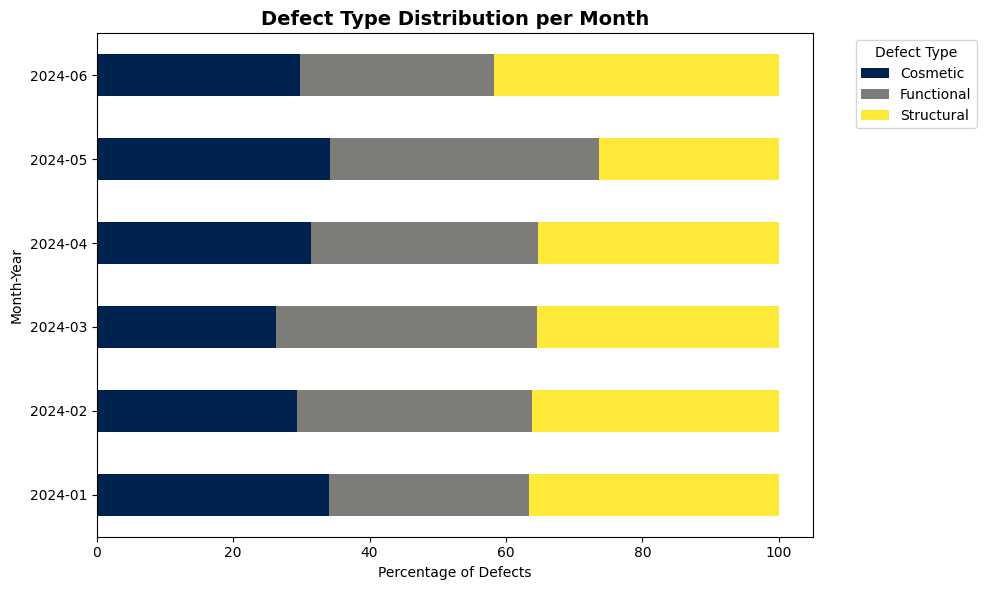

In [ ]:
# I've decided the stacked horizontal bar chart is the best way to visualize the defect type distribution per month.
# This visual leverages a color blind friendly color scheme. 
# In the book "Introduction of Storytelling with Data" by Cole Nussbaumer Knaflic, she mentions that color is a powerful tool to leverage in data visualization.
# While the color in this case is not used to highlight a specific data point, it is used to differentiate between the different defect types.

# Ensure defect_date is in datetime format
df_defects_datefix["defect_date"] = pd.to_datetime(df_defects_datefix["defect_date"])

# Extract Month-Year for grouping
df_defects_datefix["Month_Year"] = df_defects_datefix["defect_date"].dt.to_period("M")

# Count defect occurrences per month and defect type
df_pivot = df_defects_datefix.pivot_table(index="Month_Year", columns="defect_type", values="defect_id", aggfunc="count", fill_value=0)

# Convert PeriodIndex to string for plotting
df_pivot.index = df_pivot.index.astype(str)

# Normalize data to show proportions instead of raw counts
df_pivot_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
df_pivot_percent.plot(kind="barh", stacked=True, ax=ax, colormap="cividis")

# Formatting
ax.set_title("Defect Type Distribution per Month", fontsize=14, fontweight="bold")
ax.set_xlabel("Percentage of Defects")
ax.set_ylabel("Month-Year")
ax.legend(title="Defect Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()